# **Malaria Detection Using vgg19**

Team: Malar-ai.netlify.app

Biomedical Engineering
Addis Ababa Institute of Technology
Addis Ababa University

In [ ]:
!pip install opendatasets
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrahamgenetu","key":"0da3b16e3c3e59eb21cfb2b295b55b38"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Jun 18 06:21 kaggle.json


In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s malaria

ref                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
imdevskp/malaria-dataset                            Malaria Dataset                                      52KB  2020-07-01 17:28:22           5706         88  1.0              
iarunava/cell-images-for-detecting-malaria          Malaria Cell Images Dataset                         675MB  2018-12-05 05:40:21          44198       1189  0.625            
kmader/malaria-bounding-boxes                       Malaria Bounding Boxes                                4GB  2019-05-09 13:37:54           3515        118  0.75             
miracle9to9/files1                                  Malaria Dataset                                     525MB  2020-01-0

In [7]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:23<00:00, 31.8MB/s]
100% 675M/675M [00:23<00:00, 29.7MB/s]


In [8]:
!unzip /content/cell-images-for-detecting-malaria.zip


Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [9]:
# set seeds to ensure repeatability of results
import pandas as pd
import numpy as np
import os
import cv2
from numpy.random import seed
import tensorflow
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import itertools
import shutil
import pickle
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import binary_accuracy

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

## Image Preprocessing stage

In [10]:
# Define the paths to the folders containing the uninfected and parasitized images
path_uninfected = 'cell_images/Uninfected/'
path_parasitized = 'cell_images/Parasitized/'

# Get the list of files in each folder
uninfected_list = os.listdir(path_uninfected)
parasitized_list = os.listdir(path_parasitized)

# Print the number of images in each folder
print('Uninfected: ', len(uninfected_list))
print('Parasitized: ', len(parasitized_list))

Uninfected:  13780
Parasitized:  13780


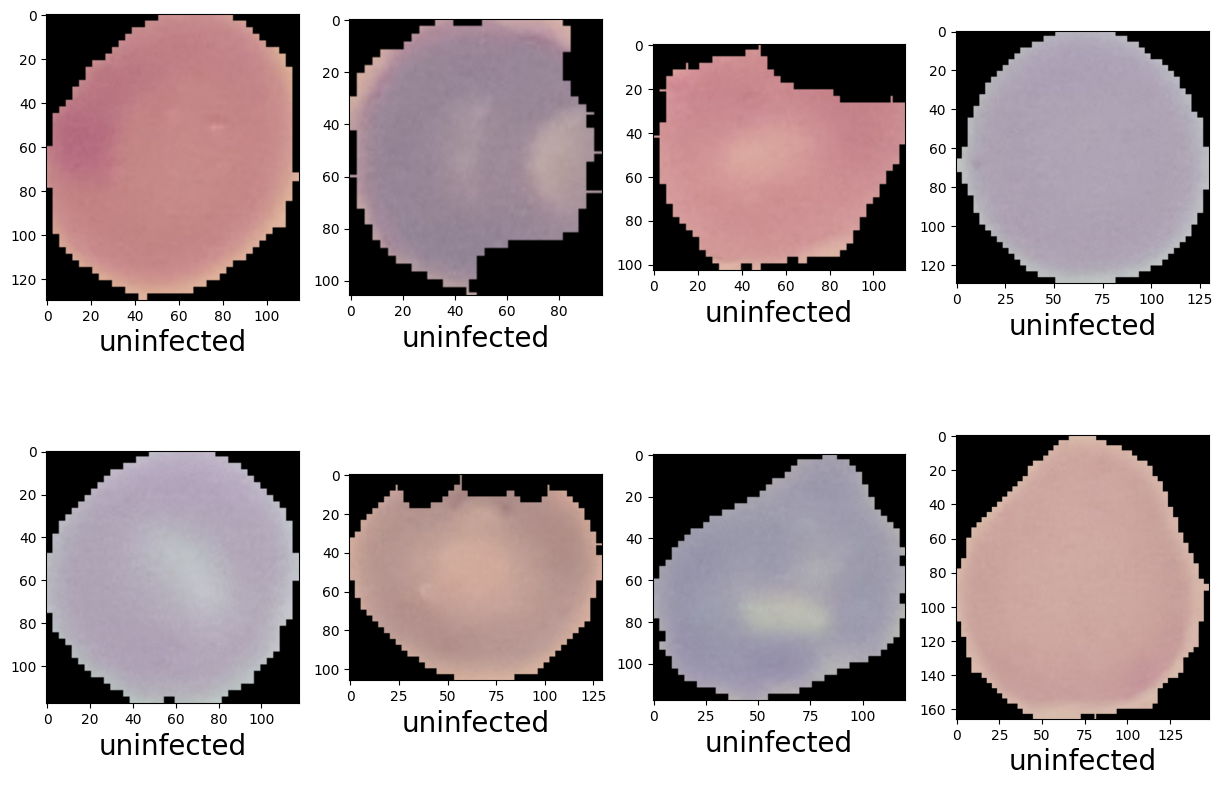

In [13]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(15,10))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image from the uninfected list
    image = uninfected_list[i]

    # Read the image file from the uninfected folder and convert it to an array
    img_array = plt.imread(path_uninfected + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'uninfected' with a font size of 20
    plt.xlabel('uninfected', fontsize=20)

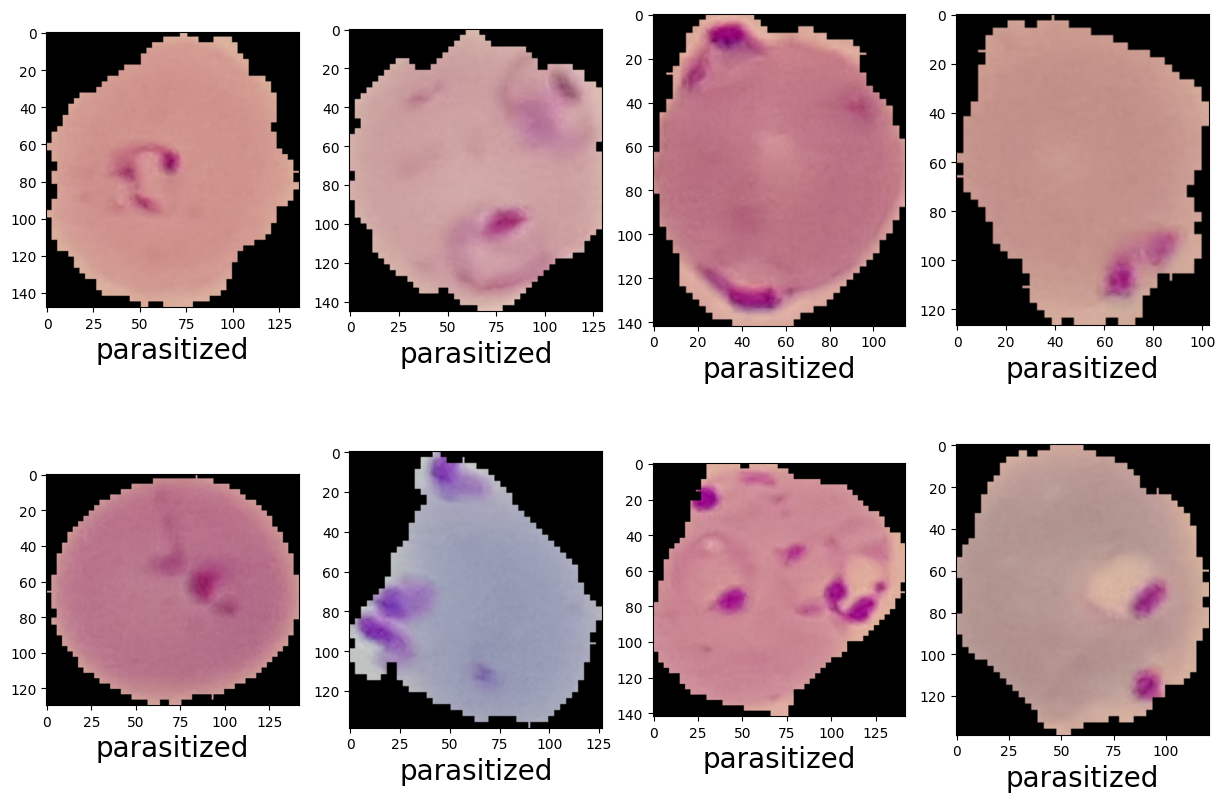

In [14]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(15,10))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image from the parasitized list
    image = parasitized_list[i]

    # Read the image file from the parasitized folder and convert it to an array
    img_array = plt.imread(path_parasitized + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'parasitized' with a font size of 20
    plt.xlabel('parasitized', fontsize=20)

## **Data Preprocessing**

In [15]:
# Check if any non-image files are present in the parasitized folder
for item in parasitized_list:
    # Split the filename into a list using '.' as the separator
    file_list = item.split('.')

    # Check if the file extension is not 'png'
    if file_list[1] != 'png':
        # Print a message indicating the non-image file found in the parasitized folder
        print('Parasitized folder: ',item)


# Check if any non-image files are present in the uninfected folder
for item in uninfected_list:
    # Split the filename into a list using '.' as the separator
    file_list = item.split('.')

    # Check if the file extension is not 'png'
    if file_list[1] != 'png':
        # Print a message indicating the non-image file found in the uninfected folder
        print('Uninfected folder: ', item)

Parasitized folder:  Thumbs.db
Uninfected folder:  Thumbs.db


In [16]:
# Create a dataframe for the uninfected images with a single column 'image_id' containing the image filenames
df_uninfected = pd.DataFrame(uninfected_list, columns=['image_id'])

# Remove any rows with the image filename 'Thumbs.db' from the uninfected dataframe
df_uninfected = df_uninfected[df_uninfected['image_id'] != 'Thumbs.db']

# Add a new column 'target' to the uninfected dataframe with all values set to 0
df_uninfected['target'] = 0

# Create a dataframe for the parasitized images with a single column 'image_id' containing the image filenames
df_parasitized = pd.DataFrame(parasitized_list, columns=['image_id'])

# Remove any rows with the image filename 'Thumbs.db' from the parasitized dataframe
df_parasitized = df_parasitized[df_parasitized['image_id'] != 'Thumbs.db']

# Add a new column 'target' to the parasitized dataframe with all values set to 1
df_parasitized['target'] = 1

# Print the shapes of the uninfected and parasitized dataframes
print(df_uninfected.shape)
print(df_parasitized.shape)

# Concatenate the uninfected and parasitized dataframes into a single dataframe, and reset the index
df_combined = pd.concat([df_uninfected, df_parasitized], axis=0).reset_index(drop=True)

# Print the shape of the combined dataframe
print(df_combined.shape)
# Check if the image names are unique.
# The output should be 27558

df_combined['image_id'].nunique()

(13779, 2)
(13779, 2)
(27558, 2)


27558

In [17]:
import cv2

def read_image_sizes(file_name):
    """
    This function reads an image file and returns its shape, max and min pixel values, and image format.
    """

    # Determine the path to the image file based on whether it is uninfected or parasitized
    if file_name in uninfected_list:
        path = path_uninfected
    else:
        path = path_parasitized

    # Read the image file using OpenCV
    image = cv2.imread(path + file_name)

    # Compute the max and min pixel values in the image
    max_pixel_val = image.max()
    min_pixel_val = image.min()

    # Extract the image format from the filename
    img_format = file_name.split('.')[1]

    # Return a list containing the image shape, max and min pixel values, and image format
    output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val, img_format]
    return output

# Apply the read_image_sizes function to each image in df_combined['image_id'], and stack the resulting arrays row-wise
m = np.stack(df_combined['image_id'].apply(read_image_sizes))

# Create a new dataframe 'df' from the stacked array, with column names 'w', 'h', 'c', 'max_pixel_val', 'min_pixel_val', and 'image_format'
df = pd.DataFrame(m, columns=['w','h','c','max_pixel_val','min_pixel_val', 'image_format'])

# Concatenate the original dataframe df_combined with the new dataframe df along axis 1, and set sort=False to suppress a warning message
df_combined = pd.concat([df_combined,df], axis=1, sort=False)

# Print the first 10 rows of the combined dataframe
df_combined.head(10)

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
0,C47P8thin_Original_Motic_IMG_20150714_093715_c...,0,124,130,3,168,0,png
1,C72P33_ThinF_IMG_20150815_105033_cell_157.png,0,130,115,3,228,0,png
2,C56P17thinF_IMG_20150728_160623_cell_18.png,0,106,97,3,217,0,png
3,C75P36_ThinF_IMG_20150815_163147_cell_2.png,0,103,115,3,225,0,png
4,C206ThinF_IMG_20151029_141047_cell_248.png,0,130,130,3,200,0,png
5,C223ThinF_IMG_20151112_103809_cell_101.png,0,118,118,3,208,0,png
6,C39P4thinF_original_IMG_20150622_105803_cell_5...,0,106,130,3,217,0,png
7,C162P123ThinF_IMG_20151116_102751_cell_146.png,0,118,121,3,190,0,png
8,C111P72ThinF_IMG_20150930_113049_cell_12.png,0,166,148,3,222,0,png
9,C145P106ThinF_IMG_20151016_154756_cell_16.png,0,106,112,3,202,0,png


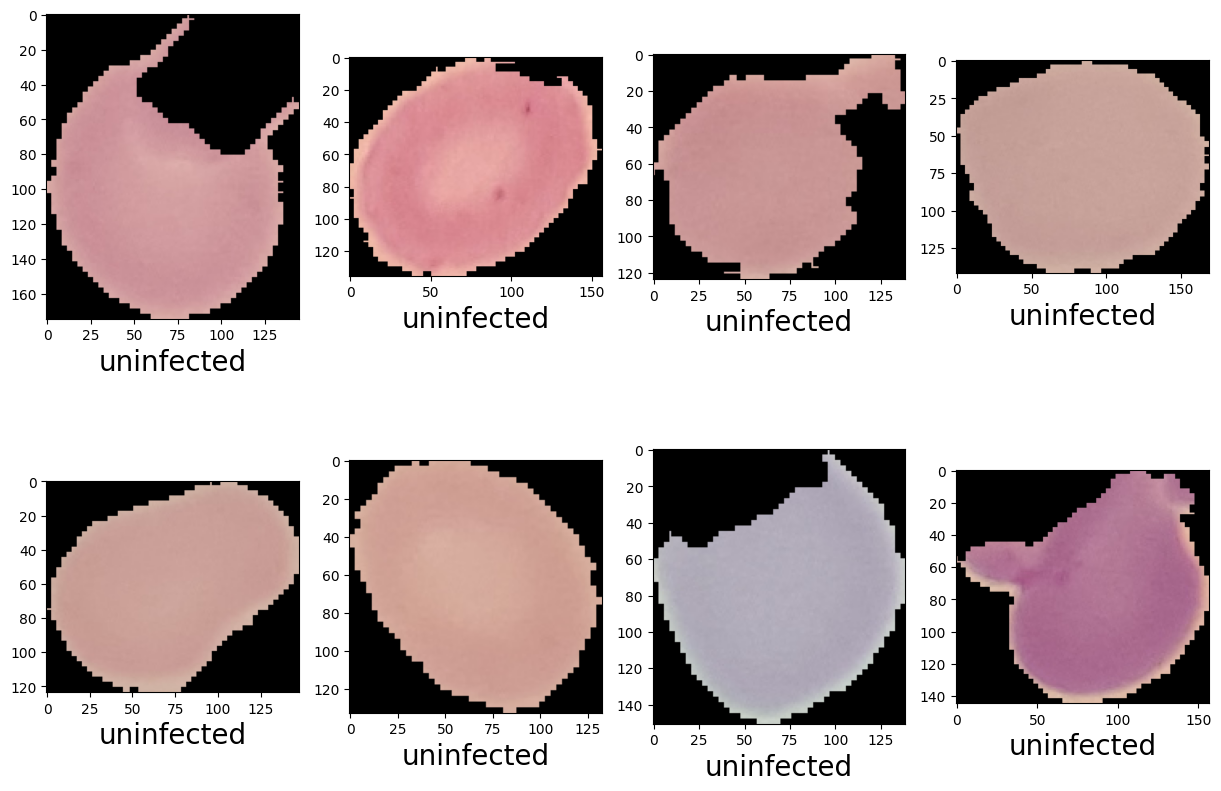

In [18]:
# Set up the canvas for the subplots with a size of 15x10 inches
plt.figure(figsize=(15,10))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image filename from the list of uninfected images
    image_list = list(df_uninfected['image_id'].sample(1))
    image = image_list[0]

    # Read the image file from the uninfected folder and convert it to an array using plt.imread()
    img_array = plt.imread(path_uninfected + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'uninfected' with a font size of 20
    plt.xlabel('uninfected', fontsize=20)

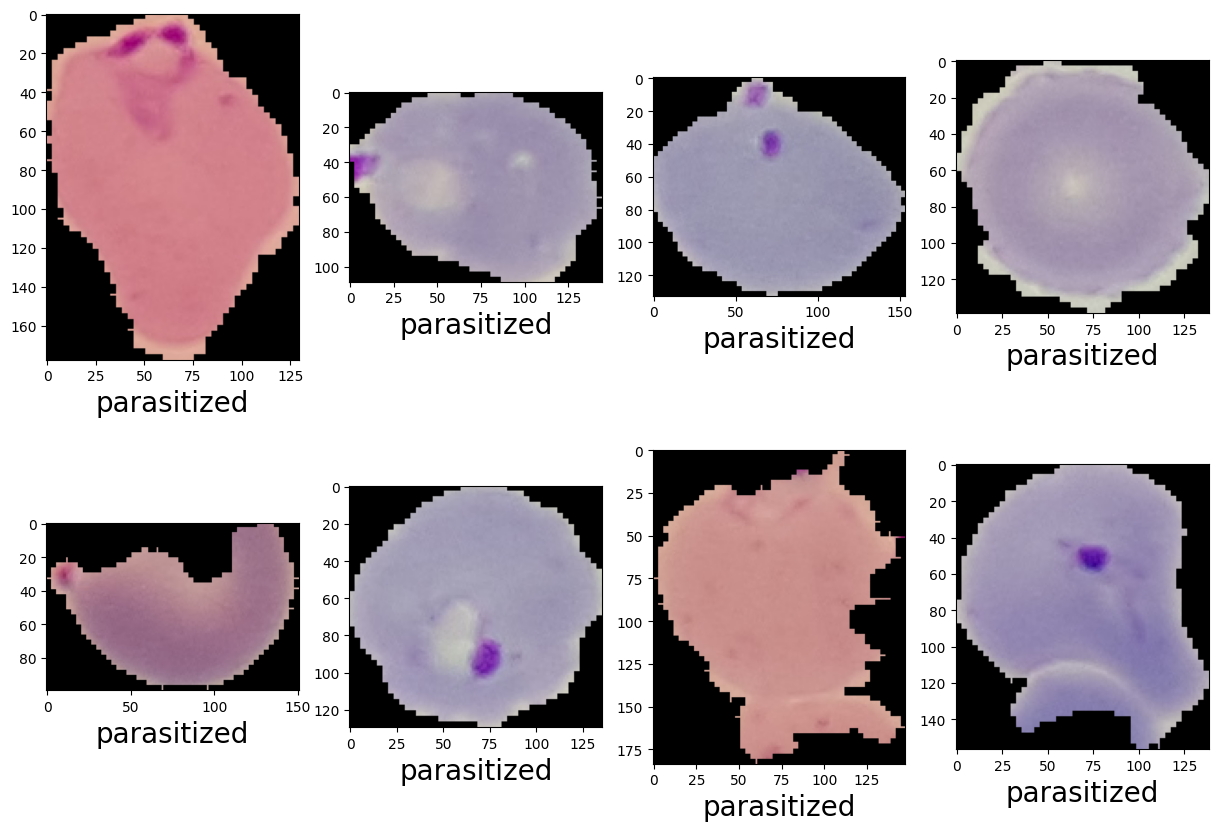

In [19]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(15,10))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image filename from the list of parasitized images
    image_list = list(df_parasitized['image_id'].sample(1))
    image = image_list[0]

    # Read the image file from the parasitized folder and convert it to an array using plt.imread()
    img_array = plt.imread(path_parasitized + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'parasitized' with a font size of 20
    plt.xlabel('parasitized', fontsize=20)

In [21]:
# Define the height and width of the images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96
IMAGE_SIZE = [224, 224]

# Specify the number of images to be held out for validation
NUM_HOLDOUT_IMAGES = 200

# Set the number of epochs to train the model for and the number of folds
NUM_EPOCHS = 20
NUM_FOLDS = 5

# Define the amount of padding to add to the images and the batch size
PADDING = 10
BATCH_SIZE = 10

# Set the number of epochs to train the final model for
NUM_FINAL_MODEL_EPOCHS = 10

In [22]:
df_combined = shuffle(df_combined, random_state=101)

# create a holdout set with 200 samples
df_holdout = df_combined.sample(NUM_HOLDOUT_IMAGES, random_state=101)

# create a list of holdout images
holdout_images_list = list(df_holdout['image_id'])


# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]

In [23]:
# Check the shapes.
# The ouput should be:
# (200, 8)
# (27358, 8)

print(df_holdout.shape)
print(df_data.shape)

(200, 8)
(27358, 8)


In [24]:
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)

In [25]:
# check if base_dir has been created
!ls


base_dir     cell-images-for-detecting-malaria.zip  sample_data
cell_images  kaggle.json


In [26]:
# select the column that we will use for stratification
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(23254, 8)
(4104, 8)


In [27]:
# The target should be approx balanced.

df_val['target'].value_counts()

0    2053
1    2051
Name: target, dtype: int64

In [28]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [29]:
path_uninfected = 'cell_images/Uninfected/'
path_parasitized = 'cell_images/Parasitized/'

# Get a list of images in each of the two folders
folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image
    target = df_data.loc[image,'target']

    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'

    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)



# Transfer the val images

for image in val_list:

    fname = image
    target = df_data.loc[image,'target']


    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'


    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst

In [30]:
# Print the number of images in each folder

# train
print(len(os.listdir('base_dir/train_dir/a_uninfected')))
print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
print(len(os.listdir('base_dir/val_dir/a_uninfected')))
print(len(os.listdir('base_dir/val_dir/b_parasitized/')))

11630
11624
2053
2051


In [31]:
from glob import glob

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
training_folders= glob('base_dir/train_dir/*')

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [42]:
# Use the Image Data Generator to import the images from the dataset in the drive
# Dimensions of one image

ImgSize = [224, 224]
batch_size = 32
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

valid_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')


Found 23254 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.


## **Transfer Learning**

In [33]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

# add preprocessing layer to the front of VGG
#include_top=False argument is to load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
vgg = VGG19(input_shape=ImgSize + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 3s 0us/step


In [34]:
# don't train existing weights
# VGG19 has many layers, so setting the entire model's trainable flag to False will freeze all the layers

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)


In [44]:
# create a model object
prediction = Dense(len(training_folders), activation='softmax')(x)

malaria_model = Model(inputs=vgg.input, outputs=prediction)


In [36]:
# view the structure of the model
malaria_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## **Model Training**

In [71]:

# tell the model what cost and optimization method to use
malaria_model.compile( loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

malaria_model.fit(training_set,
    steps_per_epoch=training_set.samples // batch_size,
    epochs=20,
    validation_data=valid_set,
    validation_steps=valid_set.samples // (batch_size*2))

Epoch 1/20
 14/726 [..............................] - ETA: 5:07 - loss: 1.1280 - accuracy: 0.5268

KeyboardInterrupt: ignored

In [47]:


#Saving this state of the model as h5 file
malaria_model.save('Malaria_VGG19.h5')

from google.colab import files
files.download('Malaria_VGG19.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
import matplotlib.pyplot as plt

# Get training and validation loss and accuracy history
history = malaria_model.history

train_loss = history.losses
val_loss = history.val_losses
train_acc = history.accs
val_acc = history.val_accs

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#This should work assuming that the `History` object returned by the `fit()` method has the `losses`, `val_losses`, `accs`, and `val_accs` attributes, which are not standard attributes of the `History` object in Keras. If these attributes are not available, you may need to modify the code to access the appropriate attributes of the `History` object.

AttributeError: ignored

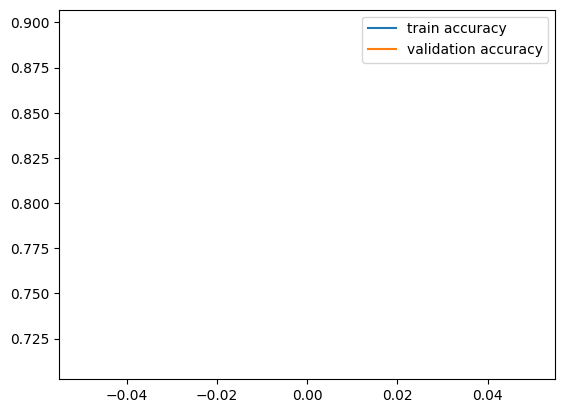

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(m.history['accuracy'], label='train accuracy')
plt.plot(m.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [72]:
#Saving this state of the model as h5 file
malaria_model.save('malaria__vgg19.h5')

#Loading the saved model (malaria_vgg19.h5) to do the testing on test data
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
# Load the saved model
malaria_model = load_model('malaria__vgg19.h5')


In [73]:
import matplotlib.pyplot as plt

# Load the saved model
malaria_model = load_model('malaria__vgg19.h5')

# Get training and validation loss and accuracy history
history = malaria_model.history

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

AttributeError: ignored

In [59]:
!ls


base_dir			       kaggle.json	  sample_data
cell_images			       malaria__vgg19.h5
cell-images-for-detecting-malaria.zip  Malaria_vgg19.h5


In [60]:
 from google.colab import files
 files.download('malaria__vgg19.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image and resize it to (224, 224)
img = load_img('/content/base_dir/val_dir/b_parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png', target_size=(224, 224))

# Convert the image to a numpy array and preprocess it
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)

# Use the model to predict the class of the test image
img_data.shape
malaria_model.predict(img_data)
a=np.argmax(malaria_model.predict(img_data), axis=1)

if(a==1):
    output_label="Uninfected"
else:
    output_label="Infected"
print(output_label)

1/1 [==============================] - 0s 19ms/step
Infected


1/1 [==============================] - 0s 164ms/step


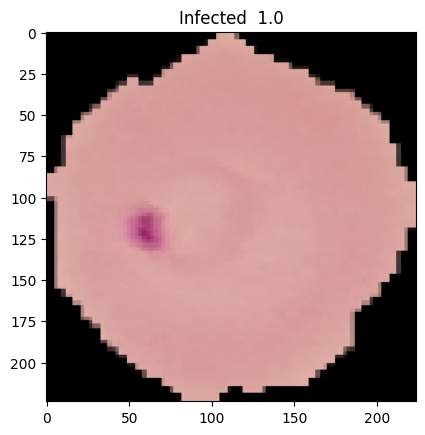

In [67]:

malaria_model.layers[0].input_shape

img1 = load_img('/content/base_dir/val_dir/b_parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png', target_size=(224, 224))
plt.imshow(img1)
img1 = np.expand_dims(img, axis=0)
result=malaria_model.predict(img1)
plt.title('{0}  {1}'.format(output_label,result[0][0]))
plt.show()

In [70]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image and resize it to (224, 224)
img = load_img('/content/base_dir/val_dir/a_uninfected/C100P61ThinF_IMG_20150918_145042_cell_5.png', target_size=(224, 224))

# Convert the image to a numpy array and preprocess it
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)

# Use the model to predict the class of the test image
img_data.shape
malaria_model.predict(img_data)
a=np.argmax(malaria_model.predict(img_data), axis=1)

if(a==1):
    output_label="Uninfected"
else:
    output_label="Infected"
print(output_label)

1/1 [==============================] - 0s 23ms/step
Infected


In [76]:

# Get the filenames, labels and associated predictions

# make a prediction
predictions = malaria_model.predict_generator(valid_set, steps=val_steps, verbose=1)


# This outputs the sequence in which the generator processed the test images
test_filenames = valid_set.filenames

# Get the true labels
y_true = valid_set.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)


129/411 [========>.....................] - ETA: 44s

411/411 [==============================] - 21s 50ms/step


In [78]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [84]:
# argmax returns the index of the max value in a row

# Get the labels of the test images.

test_labels = valid_set.classes

# We need these to plot the confusion matrix.
test_labels
# Print the label associated with each class
valid_set.class_indices

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))


valid_set.class_indices

{'a_uninfected': 0, 'b_parasitized': 1}

Confusion matrix, without normalization
[[ 552 1501]
 [ 517 1534]]


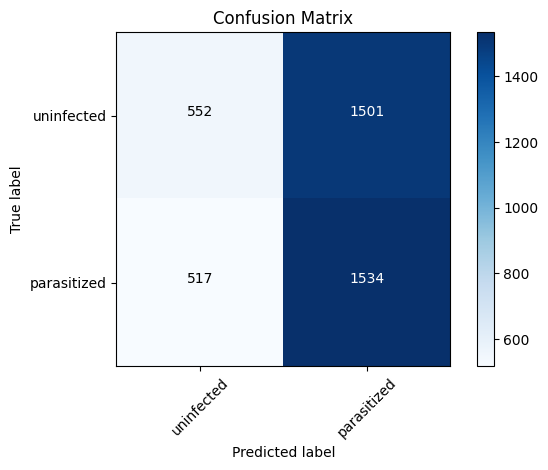

In [85]:

# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [86]:


# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

  uninfected       0.52      0.27      0.35      2053
 parasitized       0.51      0.75      0.60      2051

    accuracy                           0.51      4104
   macro avg       0.51      0.51      0.48      4104
weighted avg       0.51      0.51      0.48      4104



In [88]:
!pip install tensorflowjs


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [89]:

#Python

import tensorflowjs as tfjs


In [90]:

!tensorflowjs_converter --input_format keras Malaria_vgg19.h5 tfjs/model


2023-06-18 09:36:45.251066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [91]:


# check that the tfjs files exist
import os
os.listdir('tfjs/model')



['group1-shard5of20.bin',
 'group1-shard14of20.bin',
 'group1-shard18of20.bin',
 'group1-shard9of20.bin',
 'group1-shard13of20.bin',
 'model.json',
 'group1-shard8of20.bin',
 'group1-shard17of20.bin',
 'group1-shard19of20.bin',
 'group1-shard10of20.bin',
 'group1-shard16of20.bin',
 'group1-shard15of20.bin',
 'group1-shard2of20.bin',
 'group1-shard12of20.bin',
 'group1-shard3of20.bin',
 'group1-shard1of20.bin',
 'group1-shard4of20.bin',
 'group1-shard7of20.bin',
 'group1-shard6of20.bin',
 'group1-shard11of20.bin',
 'group1-shard20of20.bin']